# Evaluation History - Segmentation Masks

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import datetime

import numpy as np

from src.data import train_test_split, MRISequence
from src.model import create_model, compile_model, load_checkpoint
from src.model.evaluation import show_metrics

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['image.cmap'] = 'viridis'

%config InlineBackend.figure_format='retina'
plt.rcParams.update({'font.size': 15})

In [12]:
import tensorflow as tf

# RANDOM_SEED = 250398
# tf.random.set_seed(RANDOM_SEED)

print(tf.version.VERSION)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.3.2
Num GPUs Available:  1


## Setup

In [29]:
%%time

ROOT_DIR = '../../tmp'
DEFAULT_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'checkpoints')
DEFAULT_BCKP_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'bckp-checkpoints')

LOG_DIRECTORY = os.path.join(ROOT_DIR, 'logs')
CHECKPOINT_DIRECTORY = DEFAULT_CHECKPOINT_DIRECTORY_LOCAL

LOG_DIRECTORY_LOCAL = LOG_DIRECTORY
CHECKPOINT_DIRECTORY_LOCAL = CHECKPOINT_DIRECTORY

DATA_DIR_NAME = 'data-v3'
DATA_DIR = os.path.join(ROOT_DIR, DATA_DIR_NAME)

saliencies_and_segmentations_v2_path = os.path.join(ROOT_DIR, 'saliencies_and_segmentations_v2')

if not os.path.exists(CHECKPOINT_DIRECTORY):
    os.mkdir(CHECKPOINT_DIRECTORY)

if not os.path.exists(LOG_DIRECTORY):
    os.mkdir(LOG_DIRECTORY)

val = False

class_names = ['AD', 'CN']

# get paths to data
train_dir, test_dir, val_dir = train_test_split(
    saliencies_and_segmentations_v2_path,
    ROOT_DIR,
    split=(0.8, 0.15, 0.05),
    dirname=DATA_DIR_NAME)

# set the batch size for mri seq
batch_size = 12
input_shape = (104, 128, 104, 1) # (112, 112, 105, 1)
resize_img = True
crop_img = True

# if y is one-hot encoded or just scalar number
one_hot = True

# class weightss (see analysis notebook)
class_weights = {0: 0.8072289156626505, 1: 1.3137254901960784}

# description statistics of the dataset
desc = {'mean': -3.6344006e-09, 'std': 1.0000092, 'min': -1.4982183, 'max': 10.744175}

if 'desc' not in locals():
    print('initializing desc...')
    desc = get_description(MRISequence(
        train_dir,
        64,
        class_names=class_names,
        input_shape=input_shape),
        max_samples=None)
    print(desc)


normalization={ 'type':'normalization', 'desc': desc }
# normalization={'type':'standardization', 'desc':desc }

augmentations = None
augmentations_inplace = True
# enable augmentations in mri seq (otherwise it can be enabled in dataset)
# augmentations={ 'random_swap_hemispheres': 0.5 }

# initialize sequences
print('initializing train_seq...')
train_seq = MRISequence(
    train_dir,
    batch_size,
    class_names=class_names,
    augmentations=augmentations,
    augmentations_inplace=augmentations_inplace,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    class_weights=class_weights,
    normalization=normalization)

print('initializing test_seq...')
test_seq = MRISequence(
    test_dir,
    batch_size,
    class_names=class_names,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    normalization=normalization,
    segmentation=True)

if val:
    print('initializing val_seq...')
    val_seq = MRISequence(
        val_dir,
        batch_size,
        class_names=class_names,
        input_shape=input_shape,
        resize_img=resize_img,
        crop_img=crop_img,
        one_hot=one_hot,
        class_weights=class_weights,
        normalization=normalization)
else:
    print('val_seq = test_seq')
    val_seq = test_seq

model_key = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = os.path.join(LOG_DIRECTORY, model_key)
print(f'log_dir: {log_dir}')

not copying files since the destination directory already exists
initializing train_seq...
initializing test_seq...
val_seq = test_seq
log_dir: ../../tmp\logs\20210422-193357
Wall time: 5 ms


[{0: 'background / non-brain', 1: 'gray_matter', 2: 'white matter', 3: 'ventricles', 4: 'hippocampus'}
 {0: 'background / non-brain', 1: 'gray_matter', 2: 'white matter', 3: 'ventricles', 4: 'hippocampus'}
 {0: 'background / non-brain', 1: 'gray_matter', 2: 'white matter', 3: 'ventricles', 4: 'hippocampus'}
 {0: 'background / non-brain', 1: 'gray_matter', 2: 'white matter', 3: 'ventricles', 4: 'hippocampus'}
 {0: 'background / non-brain', 1: 'gray_matter', 2: 'white matter', 3: 'ventricles', 4: 'hippocampus'}
 {0: 'background / non-brain', 1: 'gray_matter', 2: 'white matter', 3: 'ventricles', 4: 'hippocampus'}
 {0: 'background / non-brain', 1: 'gray_matter', 2: 'white matter', 3: 'ventricles', 4: 'hippocampus'}
 {0: 'background / non-brain', 1: 'gray_matter', 2: 'white matter', 3: 'ventricles', 4: 'hippocampus'}
 {0: 'background / non-brain', 1: 'gray_matter', 2: 'white matter', 3: 'ventricles', 4: 'hippocampus'}
 {0: 'background / non-brain', 1: 'gray_matter', 2: 'white matter', 3: 'v

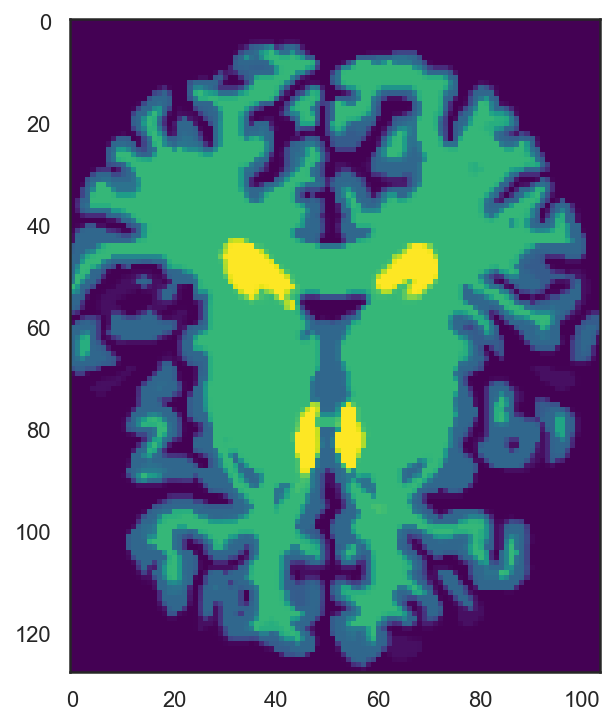

In [41]:
seg_masks = None
seg_labels = None

for batch_x, batch_y, batch_seg_masks, batch_seg_labels in test_seq:
    seg_masks = batch_seg_masks
    seg_labels = batch_seg_labels
    break
    
plt.imshow(seg_masks[0][56])
print(seg_labels)

In [7]:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights
# pos / neg
initial_bias = np.log([159/243, 243/159])

model_type = '3d_cnn'
model_config = {
    'input_shape': input_shape,
    'class_names': class_names,
#     'l2_beta': 0.001,
#     'l2_beta': 0.0005,
    'l2_beta': None,
#     'dropout': 0.05,
    'dropout': 0.10,
    'output_bias': initial_bias,
#     'output_bias': None,
    # https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization
    'batch_norm': True,
    'is_complex': False, # a complex layer from the paper, max batch_size is 3
}

compile_config = {
    # default is 0.001
#     'learning_rate': 0.000075,
    'learning_rate': 0.00010,
    'decay_steps': 25,
    'decay_rate': 0.96,
#     'beta_1': 0.85,
    'beta_1': 0.90,
#     'beta_2': 0.990,
    'beta_2': 0.999,
}

train_config = {
    'model_key': model_key,
    'epochs': 150,
    'patience': 75,
    'tensorboard_update_freq': 'epoch',
    'mri_tensorboard_callback': False,
    'model_checkpoint_callback': {'monitor': 'val_auc', 'mode': 'max', 'save_best_only': True},
    'early_stopping_monitor': {'monitor': 'val_auc', 'mode': 'max'},
#     'augmentations': False,
    'augmentations': {
        'invert': (0.5, None),
        'rotate': (0.2, 5), # probability, degrees
        'zoom': (0., 0.),
        'shear': (0.2, 0.5), # probability, degrees
        'blur': (0.2, 0.85),
        'noise': (0.2, 0.00020)
    },
    'batch_size': 8,
#     'model_checkpoint_callback': False,
}

## Model

In [8]:
model = create_model(model_type, model_config)
model, *_ = compile_model(model, **compile_config)
model.build(input_shape=input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 104, 128, 104, 32) 896       
_________________________________________________________________
batch_normalization (BatchNo (None, 104, 128, 104, 32) 128       
_________________________________________________________________
activation (Activation)      (None, 104, 128, 104, 32) 0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 52, 64, 52, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 52, 64, 52, 64)    55360     
_________________________________________________________________
batch_normalization_1 (Batch (None, 52, 64, 52, 64)    256       
_________________________________________________________________
activation_1 (Activation)    (None, 52, 64, 52, 64)    0

In [9]:
load_checkpoint(model, DEFAULT_BCKP_CHECKPOINT_DIRECTORY_LOCAL, '20210308-175324', 'cp-0058.ckpt')

loading checkpoint from ../../tmp\bckp-checkpoints\20210308-175324\cp-0058.ckpt...


In binary classification, recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”. (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
AD
precision: 0.8333333333333334
recall: 0.8064516129032258
f1-score: 0.819672131147541
support: 62


CN
precision: 0.7
recall: 0.7368421052631579
f1-score: 0.717948717948718
support: 38


micro avg
precision: 0.78
recall: 0.78
f1-score: 0.78
support: 100


macro avg
precision: 0.7666666666666666
recall: 0.7716468590831917
f1-score: 0.7688104245481295
support: 100


weighted avg
precision: 0.7826666666666666
recall: 0.78
f1-score: 0.7810172341319883
support: 100


samples avg
precision: 0.78
recall: 0.78
f1-score: 0.78
support: 100


F1
micro: 0.78
macro: 0.7688104245481295


accuracy_score: 0.78
sensitivity_score: 0.8064516129032258
specificity_score: 0.7368421052631579


Wall time: 45.4 s


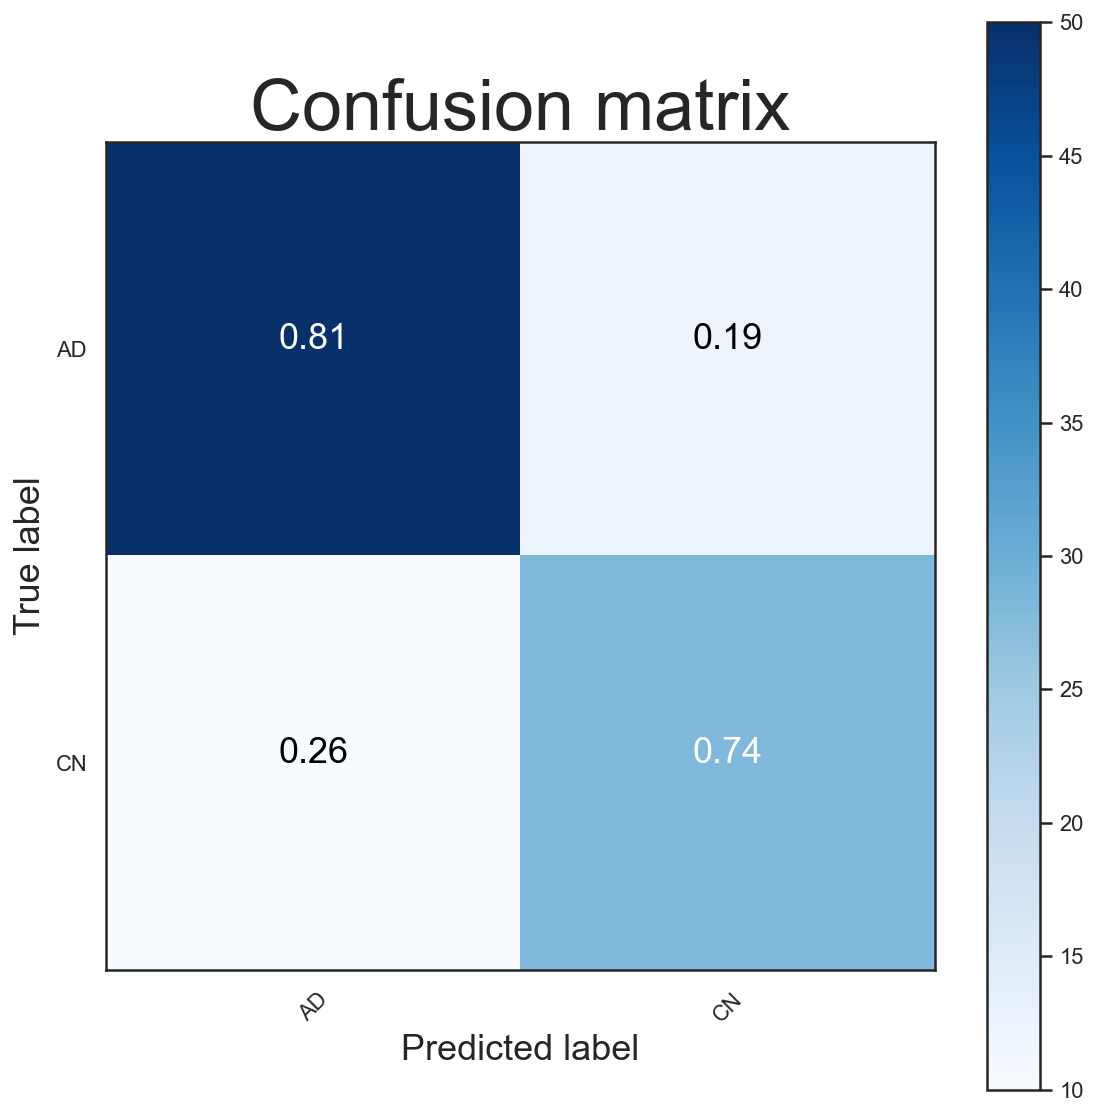

In [13]:
%%time

# just to test of it is ok to clear the session after loading the weigths
tf.keras.backend.clear_session()

show_metrics(model, test_seq, class_names)

## Evaluation

In [15]:
import time

from src.heatmaps.evaluation import get_heatmap
from src.risei import RISEI
from src.data import tf_predict

In [18]:
notebook_key = 'captum--guided-grad-cam-insertion-TP-TN-FP-FN'

BATCH_SIZE = 12

In [67]:
from src.data import select_from_dataset, numpy_to_sequence

images_x, images_y, images_y_pred, (seg_masks, seg_labels) = select_from_dataset(tf_predict(model), test_seq, max_category=20, fp_max=0, fn_max=0, seq_other=True)
print(images_x.shape)
sequence = numpy_to_sequence(images_x, images_y, batch_size=BATCH_SIZE)

tp: 20, tn: 20, fp: 0, fn: 0
(40, 104, 128, 104, 1)


In [68]:
from src.heatmaps.evaluation import HeatmapEvaluationHistory

history = HeatmapEvaluationHistory.load('../../tmp/risei-history', notebook_key)

In [ ]:
plt.imshow(seg_masks[0][56])
print(seg_labels)